****


# **SARIMA (Seasonal Autoregressive Integrated Moving Average) Model**

The SARIMA model is an extension of the ARIMA model that includes seasonal terms. Provided as SARIMA$(p, d, q)(P, D, Q)$, where the parameters model both non-seasonal and seasonal components of the time-series.

$(1 - \phi_1 L - \phi_2 L^2 - \ldots - \phi_p L^p)(1 - L)^d(1 - \Phi_1 L^s - \Phi_2 L^{2s} - \ldots - \Phi_P L^{Ps})Y_t = (1 + \theta_1 L + \theta_2 L^2 + \ldots + \theta_q L^q)(1 + \Theta_1 L^s + \Theta_2 L^{2s} + \ldots + \Theta_Q L^{Qs})\epsilon_t$  \\

\

$Y_t$: The value of the series at time $t$. \\
$\phi_1, \phi_2, \ldots, \phi_p$: Non-seasonal autoregressive coefficients. \\
$\Phi_1, \Phi_2, \ldots, \Phi_P$: Seasonal autoregressive coefficients. \\
$L$: Lag operator. \\
$p$: Order of the non-seasonal autoregressive part. \\
$P$: Order of the seasonal autoregressive part. \\
$(1 - L)^d$: Non-seasonal differencing operator for stationarity. \\
$(1 - L^s)^D$: Seasonal differencing operator for stationarity. \\
$d$: Order of non-seasonal differencing. \\
$D$: Order of seasonal differencing. \\
$s$: Seasonal period. \\
$\theta_1, \theta_2, \ldots, \theta_q$: Non-seasonal moving average coefficients. \\
$\Theta_1, \Theta_2, \ldots, \Theta_Q$: Seasonal moving average coefficients. \\
$q$: Order of the non-seasonal moving average part. \\
$Q$: Order of the seasonal moving average part. \\
$\epsilon_t$: Error term at time $t$.






****

****

**Monthly Average Weather Readings for South Florida**

**From https://dev.meteostat.net/**


****

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

!pip install meteostat
from meteostat import Stations
from datetime import datetime
from meteostat import Monthly

In [ ]:
latitude = 25.7617
longitude = -80.1918

In [ ]:
stations = Stations()
stations = stations.nearby(latitude, longitude)
station = stations.fetch(1)

In [ ]:
station

,name,country,region,wmo,icao,latitude,longitude,elevation,timezone,hourly_start,hourly_end,daily_start,daily_end,monthly_start,monthly_end,distance
id,,,,,,,,,,,,,,,,
72202,Miami International Airport,US,FL,72202,KMIA,25.7833,-80.3167,4.0,America/New_York,1973-01-01,2024-03-03,1948-01-01,2024-12-30,1948-01-01,2022-01-01,12735.283267


In [ ]:
station_id = '72202'
start = datetime(2007, 1, 1)
end = datetime(2023, 12, 30)

In [ ]:
data = Monthly(station_id, start, end)
weather = data.fetch()

In [ ]:
weather = weather.fillna(method='ffill').fillna(method='bfill')

In [ ]:
weather['month'] = weather.index.month
weather['year'] = weather.index.year

In [ ]:
weather = weather.rename(columns={'tavg': 'TEMPERATURE'})

In [ ]:
weather.reset_index(inplace=True)
weather.rename(columns={'time': 'DATE'}, inplace=True)
weather.set_index('DATE', inplace=True)

In [ ]:
weather = weather[['TEMPERATURE', 'year', 'month']]

In [ ]:
weather.sort_index(axis=1)
numeric_mean = weather.mean(numeric_only=True)

In [ ]:
weather.fillna(numeric_mean, inplace=True)

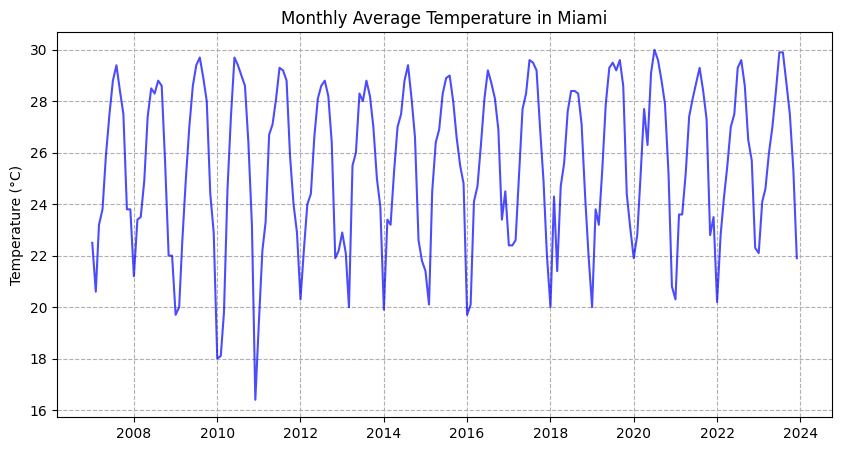

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(weather['TEMPERATURE'], color='blue', alpha=0.7)
plt.title('Monthly Average Temperature in Miami')
plt.ylabel('Temperature (°C)')
plt.grid(True, linestyle='--')

In [ ]:
!pip install pmdarima
!pip install statsmodels
from pmdarima import auto_arima
from statsmodels.tsa.arima_model import ARMA,ARMAResults
from statsmodels.tsa.arima.model import ARIMA,ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings("ignore")

****

# **Analysis of Average Monthly Weather Temperatures °C in Miami, Florida**

****

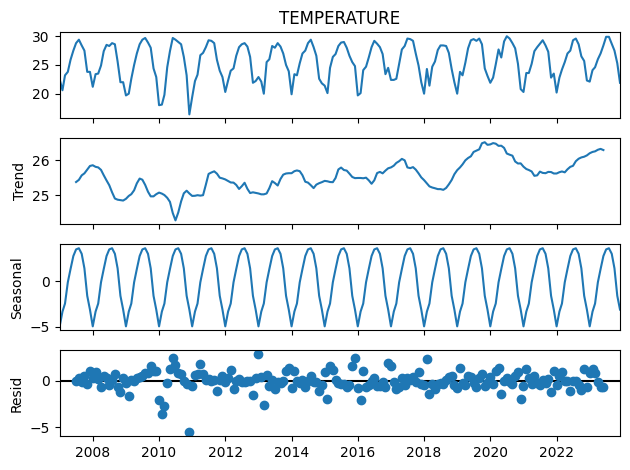

In [ ]:
result = seasonal_decompose(weather['TEMPERATURE'], model='add')
result.plot();

****

**The average temperature data has a strong seasonal pattern, as shown by the regular cycles in the seasonal component.**

**There appears to be a long-term trend in the data, but it is not strictly linear, indicating changing average temperatures over the years.**

**The residuals do not show any clear patterns, suggesting that the model used for decomposition has done a good job capturing the underlying structure of the data.**

**Since the decomposition has extracted the trend and seasonal components effectively, predictions or further analyses can be made with more confidence, using the residual component to gauge the unexplained variation in the data.**

****

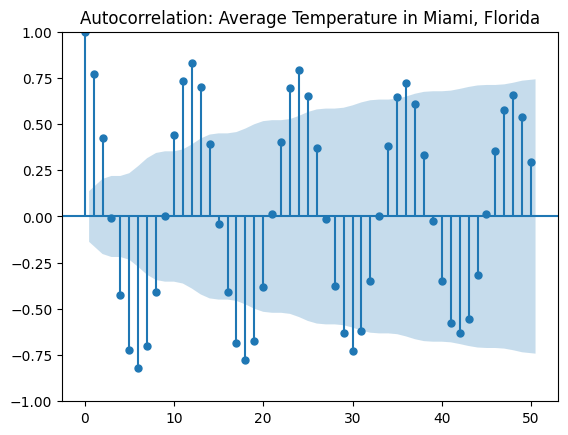

In [ ]:
title = 'Autocorrelation: Average Temperature in Miami, Florida'
lags = 50
plot_acf(weather['TEMPERATURE'],title=title,lags=lags);

****

**The ACF chart displays a slow decay in correlation as the lag increases, which usually indicates a non-stationary time series.**

**The significant spikes at consistent intervals suggest a seasonal pattern. For a stationary time series, we would expect the ACF to drop to near zero relatively quickly, which is not observed here.**

**The data may benefit from seasonal differencing to achieve stationarity.**

****

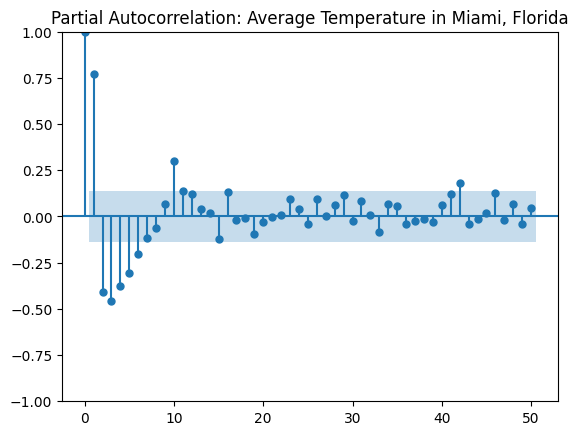

In [ ]:
title = 'Partial Autocorrelation: Average Temperature in Miami, Florida'
lags = 50
plot_pacf(weather['TEMPERATURE'],title=title,lags=lags);

****

**The PACF chart shows a sharp drop after the first lag and then tapers off into what appears to be white noise (fluctuations around zero).**

**This suggests that there is a significant partial correlation at lag 1, after which the influence of further lags is minimal.**

**This kind of pattern typically indicates an "AR signature," where the series can be effectively modeled using autoregressive terms.**

****

In [ ]:
!pip install scipy
from scipy.stats import mannwhitneyu, spearmanr, kendalltau

In [ ]:
mk_test_result = kendalltau(weather.index, weather['TEMPERATURE'])
print(f"Mann-Kendall Test statistic: {mk_test_result.statistic}, p-value: {mk_test_result.pvalue}")

Mann-Kendall Test statistic: 0.06767740372487642, p-value: 0.15262239741001835


In [ ]:
ordinal_dates = weather.index.map(pd.Timestamp.toordinal)
spearman_test_result = spearmanr(ordinal_dates, weather['TEMPERATURE'])
print(f"Spearman's Rho Test statistic: {spearman_test_result.correlation}, p-value: {spearman_test_result.pvalue}")

Spearman's Rho Test statistic: 0.0991385565488657, p-value: 0.1583157778720542


In [ ]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC')

    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val

    print(out.to_string())

    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

****

**Augmented Dickey-Fuller Test results show that the data is Non-Stationary.**

****

In [ ]:
adf_test(weather['TEMPERATURE'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -2.493866
p-value                   0.116974
# lags used              14.000000
# observations          189.000000
critical value (1%)      -3.465431
critical value (5%)      -2.876957
critical value (10%)     -2.574988
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


****

**Stationarity is a necessary prerequisite for ARIMA modeling**

**Stationarity means that the properties of the series (mean, variance, autocorrelation) remain constant over time.**

**We can perform a First Order Difference Transformation to Achieve Stationarity**

$
\Delta Y_t = Y_t - Y_{t-1}
$

$
\text{where:} \\
\Delta Y_t \text{ is the first-order differenced value at time } t. \\
Y_t \text{ is the original series value at time } t. \\
Y_{t-1} \text{ is the original series value at time } t-1.
$


****

In [ ]:
from statsmodels.tsa.statespace.tools import diff
weather['TEMPERATURE_DIFF_1'] = diff(weather['TEMPERATURE'],k_diff=1).fillna(0)

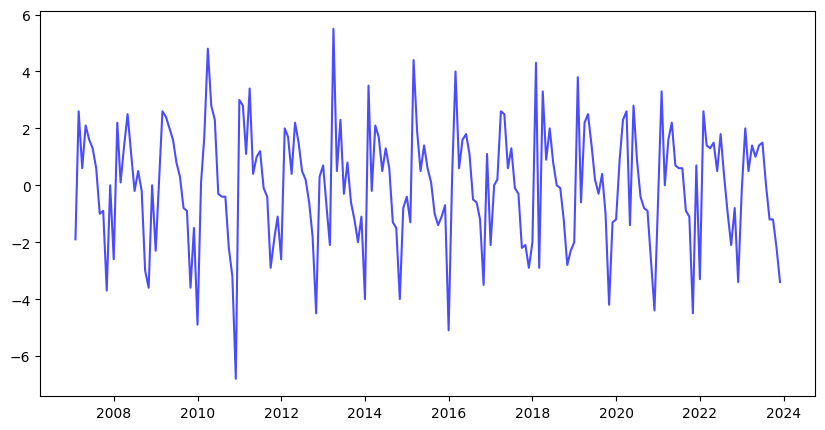

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(weather['TEMPERATURE_DIFF_1'], color='blue', alpha=0.7)

In [ ]:
adf_test(weather['TEMPERATURE_DIFF_1'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -6.344517e+00
p-value                 2.703493e-08
# lags used             1.400000e+01
# observations          1.880000e+02
critical value (1%)    -3.465620e+00
critical value (5%)    -2.877040e+00
critical value (10%)   -2.575032e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [ ]:
weather['TEMPERATURE_DIFF_1'].isna().sum()

1

In [ ]:
weather['TEMPERATURE_DIFF_1'] = weather['TEMPERATURE_DIFF_1'].fillna(0)

In [ ]:
weather['TEMPERATURE_DIFF_1'].isna().sum()

0

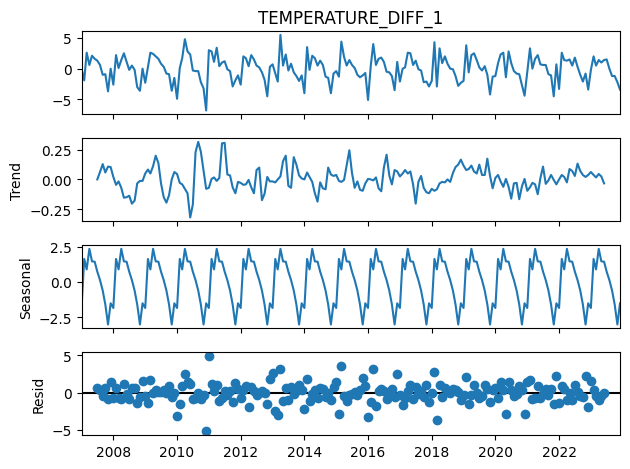

In [ ]:
result = seasonal_decompose(weather['TEMPERATURE_DIFF_1'], model='add')
result.plot();

In [ ]:
auto_arima(weather['TEMPERATURE_DIFF_1'])

ARIMA(order=(5, 0, 1), scoring_args={}, suppress_warnings=True)

In [ ]:
auto_arima(weather['TEMPERATURE_DIFF_1'],seasonal=True,error_action='ignore').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  204
Model:               SARIMAX(5, 0, 1)   Log Likelihood                -349.476
Date:                Wed, 06 Mar 2024   AIC                            714.952
Time:                        20:33:13   BIC                            741.497
Sample:                    01-01-2007   HQIC                           725.690
                         - 12-01-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0045      0.002      1.980      0.048    4.52e-05       0.009
ar.L1          0.5489      0.069      7.968      0.000       0.414       0.684
ar.L2          0.1586      0.074      2.143      0.032       0.014       0.304
ar.L3         -0.1109      0.096     -1.155      0.248      -0.299       0.077
ar.L4         -0.1546      0.101     -1.530      0.126      -0.353       0.043
ar.L5         -0.3485      0.075     -4.628      0.000      -0.496      -0.201
ma.L1         -0.9888      0.053    -18.589      0.000      -1.093      -0.885
sigma2         1.7171      0.150     11.455      0.000       1.423       2.011
===================================================================================
Ljung-Box (L1) (Q):                   1.59   Jarque-Bera (JB):                32.35
Prob(Q):                              0.21   Prob(JB):                         0.00
Heteroskedasticity (H):               0.82   Skew:                            -0.61
Prob(H) (two-sided):                  0.42   Kurtosis:                         4.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
stepwise_fit2 = auto_arima(weather['TEMPERATURE_DIFF_1'],
                          seasonal=True,
                          m=12,
                          stepwise=True,
                          error_action='ignore',
                          suppress_warnings=True,
                          trace=True)

stepwise_fit2.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=749.361, Time=3.82 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=877.235, Time=0.08 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=809.792, Time=0.47 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=847.506, Time=0.47 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=875.235, Time=0.04 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=inf, Time=5.65 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=inf, Time=2.99 sec
 ARIMA(2,0,2)(2,0,1)[12] intercept   : AIC=736.442, Time=4.88 sec
 ARIMA(2,0,2)(2,0,0)[12] intercept   : AIC=782.114, Time=3.12 sec
 ARIMA(2,0,2)(2,0,2)[12] intercept   : AIC=inf, Time=5.95 sec
 ARIMA(2,0,2)(1,0,2)[12] intercept   : AIC=765.290, Time=3.46 sec
 ARIMA(1,0,2)(2,0,1)[12] intercept   : AIC=690.147, Time=2.78 sec
 ARIMA(1,0,2)(1,0,1)[12] intercept   : AIC=683.142, Time=2.90 sec
 ARIMA(1,0,2)(0,0,1)[12] intercept   : AIC=inf, Time=1.53 sec
 ARIMA(1,0,2)(1,0,0)[12] intercept   : AIC=inf, T

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  204
Model:             SARIMAX(1, 0, 2)x(1, 0, [1], 12)   Log Likelihood                -334.571
Date:                              Wed, 06 Mar 2024   AIC                            683.142
Time:                                      20:34:20   BIC                            706.369
Sample:                                  01-01-2007   HQIC                           692.538
                                       - 12-01-2023                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.625e-05      0.000      0.143      0.886      -0.000       0.000
ar.L1          0.5417      0.189      2.862      0.004       0.171       0.913
ma.L1         -1.1797      0.195     -6.048      0.000      -1.562      -0.797
ma.L2          0.1986      0.182      1.093      0.275      -0.158       0.555
ar.S.L12       0.9899      0.010     96.398      0.000       0.970       1.010
ma.S.L12      -0.8069      0.089     -9.104      0.000      -0.981      -0.633
sigma2         1.3725      0.129     10.605      0.000       1.119       1.626
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               138.09
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               0.39   Skew:                            -0.98
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
train = weather.iloc[:150]
test = weather.iloc[150:]

In [ ]:
train['TEMPERATURE_DIFF_1'].iloc[:10]

DATE
2007-01-01    0.0
2007-02-01   -1.9
2007-03-01    2.6
2007-04-01    0.6
2007-05-01    2.1
2007-06-01    1.6
2007-07-01    1.3
2007-08-01    0.6
2007-09-01   -1.0
2007-10-01   -0.9
Name: TEMPERATURE_DIFF_1, dtype: float64

In [ ]:
test['TEMPERATURE_DIFF_1'].iloc[:10]

DATE
2019-07-01    0.2
2019-08-01   -0.3
2019-09-01    0.4
2019-10-01   -1.0
2019-11-01   -4.2
2019-12-01   -1.3
2020-01-01   -1.2
2020-02-01    0.9
2020-03-01    2.3
2020-04-01    2.6
Name: TEMPERATURE_DIFF_1, dtype: float64

****

# **SARIMA Model Fitting**

## (1, 0, 2)x(1, 0, [1], 12)


$(1 - \phi_1 L)(1 - \Phi_1 L^{12})Y_t = (1 + \theta_1 L + \theta_2 L^2)(1 + \Theta_1 L^{12})\epsilon_t$  \\
$\text{where:}$ \\
$Y_t$: The value of the series at time $t$. \\
$\phi_1$: Non-seasonal autoregressive coefficient at lag 1. \\
$\Phi_1$: Seasonal autoregressive coefficient at seasonal lag 12. \\
$L$: Lag operator. \\
$(1 - L)^d$: Non-seasonal differencing operator (not used here as \(d=0\)). \\
$(1 - L^{12})^D$: Seasonal differencing operator (not used here as \(D=0\)). \\
$\theta_1, \theta_2$: Non-seasonal moving average coefficients at lags 1 and 2. \\
$\Theta_1$: Seasonal moving average coefficient at seasonal lag 12. \\
$\epsilon_t$: Error term at time $t$.



****

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
model = SARIMAX(weather['TEMPERATURE_DIFF_1'],
                order=(1, 0, 2),
                seasonal_order=(1, 0, 1, 12),
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit()

print(results.summary())

                                      SARIMAX Results                                       
Dep. Variable:                   TEMPERATURE_DIFF_1   No. Observations:                  204
Model:             SARIMAX(1, 0, 2)x(1, 0, [1], 12)   Log Likelihood                -292.438
Date:                              Wed, 06 Mar 2024   AIC                            596.877
Time:                                      20:34:20   BIC                            616.327
Sample:                                  01-01-2007   HQIC                           604.757
                                       - 12-01-2023                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3693      0.233     -1.584      0.113      -0.826       0.088
ma.L1         -0.41

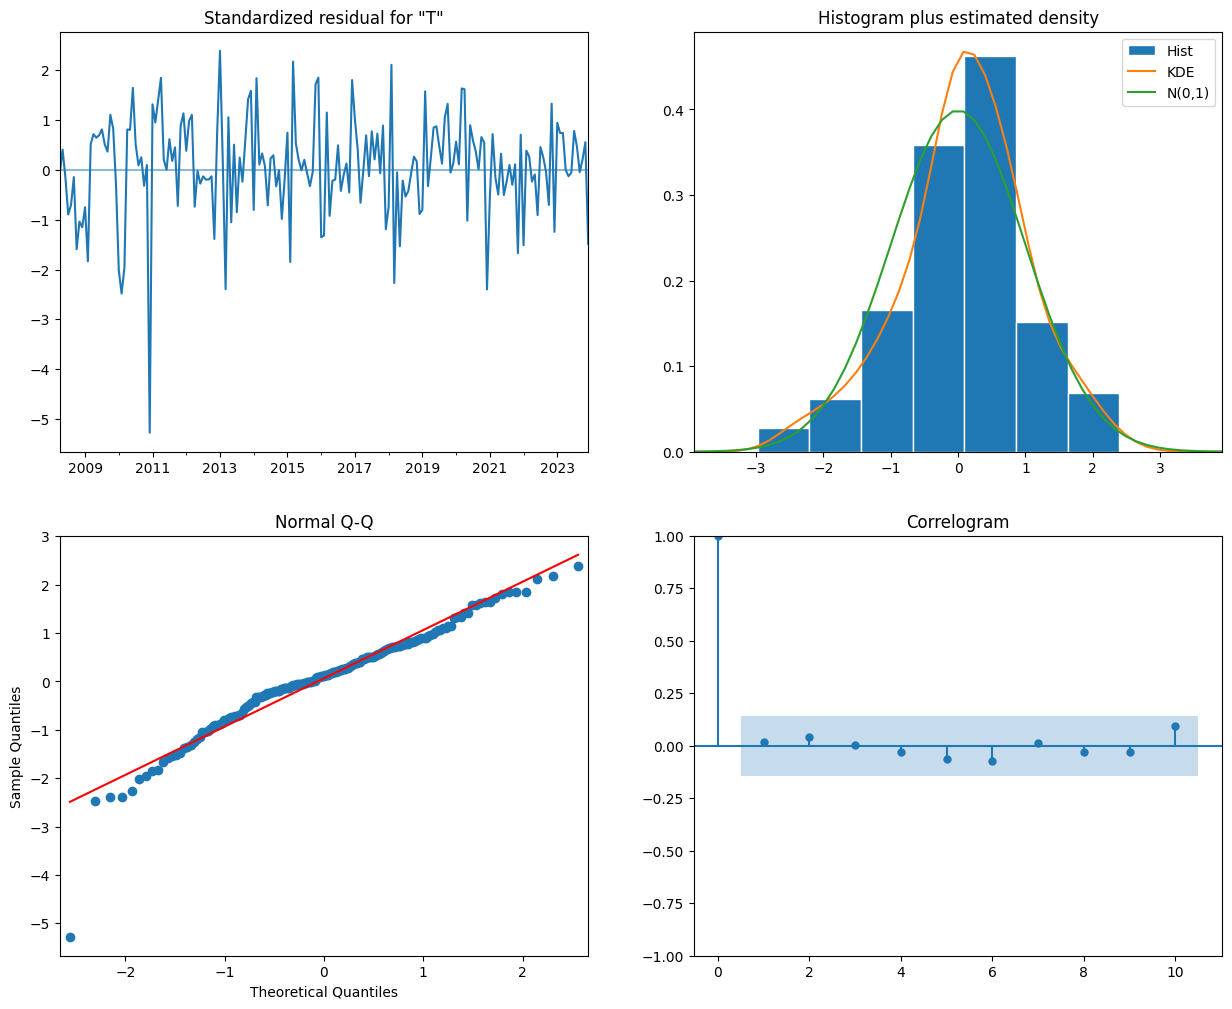

In [ ]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [ ]:
start = len(train)
end = len(train) + len(test) - 1
differenced_predictions = diff_results.predict(start=start, end=end).rename('DIFF_PREDICTION')


In [ ]:
last_train_value = train['TEMPERATURE'].iloc[-1]
weather['DIFF_PREDICTION'] = last_train_value
weather['DIFF_PREDICTION'].iloc[start:end+1] += differenced_predictions.cumsum()

In [ ]:
weather[['TEMPERATURE', 'DIFF_PREDICTION']].iloc[150:]

,TEMPERATURE,DIFF_PREDICTION
DATE,,
2019-07-01,29.5,29.285478
2019-08-01,29.2,28.693404
2019-09-01,29.6,27.355683
2019-10-01,28.6,25.632139
2019-11-01,24.4,23.926290
2019-12-01,23.1,22.698468
2020-01-01,21.9,22.272981
2020-02-01,22.8,22.752805
2020-03-01,25.1,23.995263


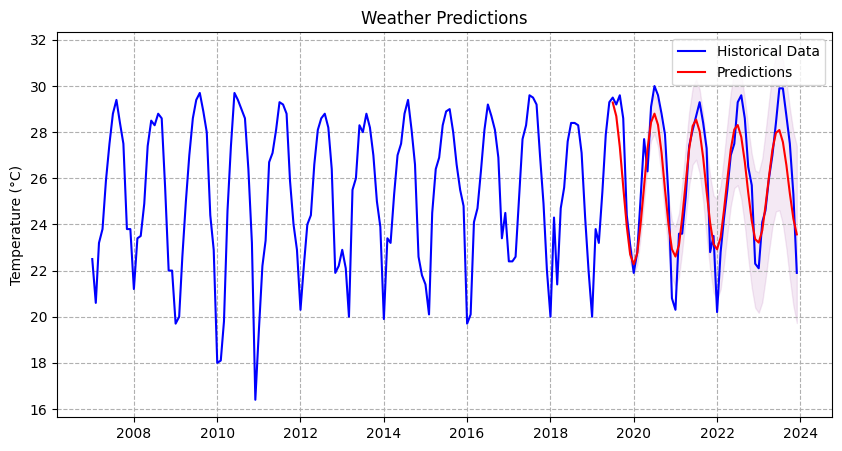

In [ ]:
start_date = '2019-07-01'
end_date = '2023-12-01'
filtered_data1 = weather.loc[start_date:end_date]
plt.figure(figsize=(10, 5))
plt.plot(weather['TEMPERATURE'], label='Historical Data', color='blue')
plt.plot(filtered_data1.index, filtered_data1['DIFF_PREDICTION'], label='Predictions', color='red')
num_points = len(filtered_data1['DIFF_PREDICTION'])
dynamic_std_dev = np.linspace(0, filtered_data1['DIFF_PREDICTION'].std() * 1.85, num_points)
plt.fill_between(filtered_data1.index,
                 filtered_data1['DIFF_PREDICTION'] - dynamic_std_dev,
                 filtered_data1['DIFF_PREDICTION'] + dynamic_std_dev,
                 color='purple', alpha=0.085)
plt.title('Weather Predictions')
plt.ylabel('Temperature (°C)')
plt.grid(True, linestyle='--')
plt.legend()
plt.show()

****

# **Metrics Evaluation**

****

****

**MAPE measures the size of the error as a  percentage,**

**&nbsp;&nbsp;&nbsp;&nbsp;$MAPE = \frac{100\%}{n} \sum\limits_{n=1}^n \left| \frac{y_{i} - \hat{y}_{i}}{y_{i}} \right|$<br><br>**

**MAE is the average of the absolute differences between the predicted and actual values,**

**&nbsp;&nbsp;&nbsp;&nbsp;$MAE = \frac{1}{n} \sum\limits_{n=1}^n |y_{i} - \hat{y}_{i}|$<br><br>**


**RMSE represents the square root of the average of the squares of these differences;**

**&nbsp;&nbsp;&nbsp;&nbsp;$RMSE = \sqrt{{\frac 1 n} \sum\limits_{n=1}^n (y_{i} - \hat y_{i})^2}$<br><br>**

****

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tools.eval_measures import rmse

In [ ]:
test['DIFF_PREDICTION'] = weather['DIFF_PREDICTION'].iloc[start:end+1]
error1 = mean_absolute_error(test['TEMPERATURE'], test['DIFF_PREDICTION'])
error2 = mean_squared_error(test['TEMPERATURE'], test['DIFF_PREDICTION'])
error3 = rmse(test['TEMPERATURE'], test['DIFF_PREDICTION'])
mape = np.mean(np.abs((test['TEMPERATURE'] - test['DIFF_PREDICTION']) / test['TEMPERATURE'])) * 100

In [ ]:
print(f'SARIMAX(1, 0, 2)x(1, 0, [1], 12) MAPE: {mape}%')
print(f'SARIMAX(1, 0, 2)x(1, 0, [1], 12) MAE: {error1}')
print(f'SARIMAX(1, 0, 2)x(1, 0, [1], 12) MSE: {error2}')
print(f'SARIMAX(1, 0, 2)x(1, 0, [1], 12) RMSE: {error3}')

SARIMAX(1, 0, 2)x(1, 0, [1], 12) MAPE: 4.259538884882078%
SARIMAX(1, 0, 2)x(1, 0, [1], 12) MAE: 1.1053575237316269
SARIMAX(1, 0, 2)x(1, 0, [1], 12) MSE: 1.836321517586582
SARIMAX(1, 0, 2)x(1, 0, [1], 12) RMSE: 1.3551094116662985


****

**The mean absolute error is less than 2 degree Celsius. This indicates that, on average, the model's predictions are within 2 degree Celsius of the actual values.**

**An MSE of 1.0734, given the range of temperatures, is reasonable as it suggests that the model doesn't often make large errors in its predictions.**

**Considering the temperature range, this level of RMSE is generally considered good for weather forecasting, where a degree or two of error can be expected.**

****

****

**Re-train the model on the entire data, not training set, and forecast future**

****

In [ ]:
model7 = SARIMAX(weather['TEMPERATURE_DIFF_1'],
                order=(1, 0, 2),
                seasonal_order=(1, 0, 1, 12),
                enforce_stationarity=False,
                enforce_invertibility=False)

diff_results2 = model7.fit()

print(diff_results2.summary())

                                      SARIMAX Results                                       
Dep. Variable:                   TEMPERATURE_DIFF_1   No. Observations:                  204
Model:             SARIMAX(1, 0, 2)x(1, 0, [1], 12)   Log Likelihood                -292.438
Date:                              Wed, 06 Mar 2024   AIC                            596.877
Time:                                      20:34:23   BIC                            616.327
Sample:                                  01-01-2007   HQIC                           604.757
                                       - 12-01-2023                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3693      0.233     -1.584      0.113      -0.826       0.088
ma.L1         -0.41

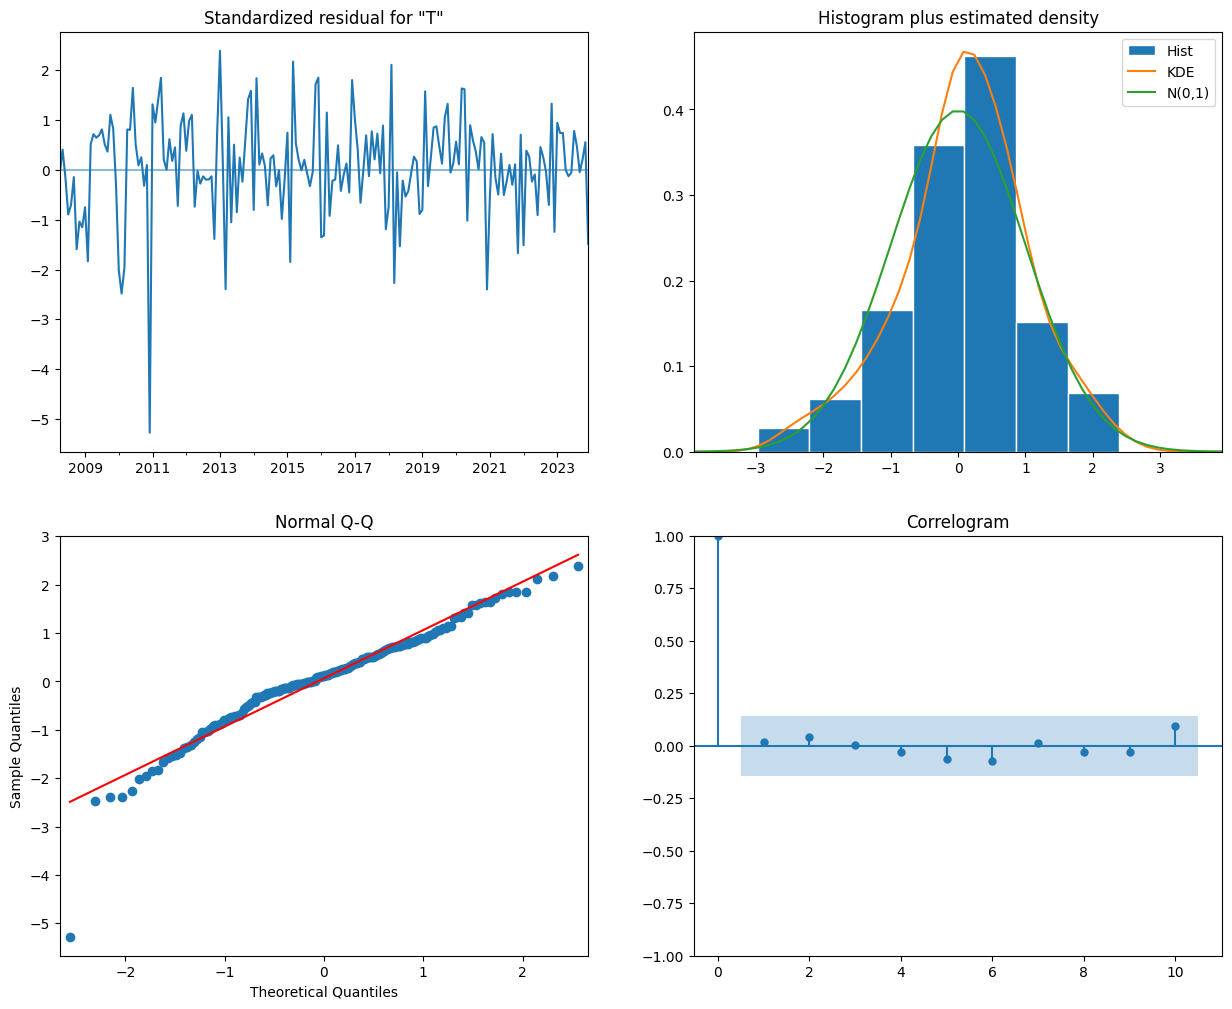

In [ ]:
diff_results2.plot_diagnostics(figsize=(15, 12))
plt.show()

In [ ]:
diff_weather_forecast = diff_results2.predict(len(weather),len(weather)+60,typ='levels').rename('FORECAST')

In [ ]:
last_observation = weather['TEMPERATURE'].iloc[-1]
forecasted_temps_diff = last_observation + diff_weather_forecast.cumsum()
future_dates2 = pd.date_range(start=weather.index[-1], periods=61, freq='MS')[1:]

In [ ]:
future_dates_index = pd.date_range(start=weather.index[-1], periods=len(diff_weather_forecast)+1, freq='MS')[1:]
future_forecast_df = pd.DataFrame(index=future_dates_index, data={'DIFF_FORECAST': forecasted_temps_diff.values})
last_date_in_extended = weather.index[-1]
additional_dates = pd.date_range(start=last_date_in_extended + pd.Timedelta(days=1), end=future_dates_index[-1], freq='MS')
additional_df = pd.DataFrame(index=additional_dates, columns=weather.columns)
extended_weather = pd.concat([weather, additional_df])

In [ ]:
historical_weather = extended_weather[extended_weather.index < future_dates_index[0]]
future_weather = pd.DataFrame()
future_weather['DIFF_FORECAST'] = future_forecast_df['DIFF_FORECAST']
extended_weather2 = pd.concat([historical_weather, future_forecast_df]).sort_index()
extended_weather2['DIFF_FORECAST'] = extended_weather2['DIFF_FORECAST'].astype('float').fillna(0.0)
extended_weather2[['TEMPERATURE', 'DIFF_FORECAST']]['2023-08-01':'2026-02-01']

,TEMPERATURE,DIFF_FORECAST
2023-08-01,29.9,0.000000
2023-09-01,28.7,0.000000
2023-10-01,27.5,0.000000
2023-11-01,25.3,0.000000
2023-12-01,21.9,0.000000
2024-01-01,NaN,21.335958
2024-02-01,NaN,23.271096
2024-03-01,NaN,23.876482
2024-04-01,NaN,25.934533
2024-05-01,NaN,27.220622


In [ ]:
start_date = '2024-01-01'
end_date = '2028-11-01'
filtered_data = extended_weather2.loc[start_date:end_date]

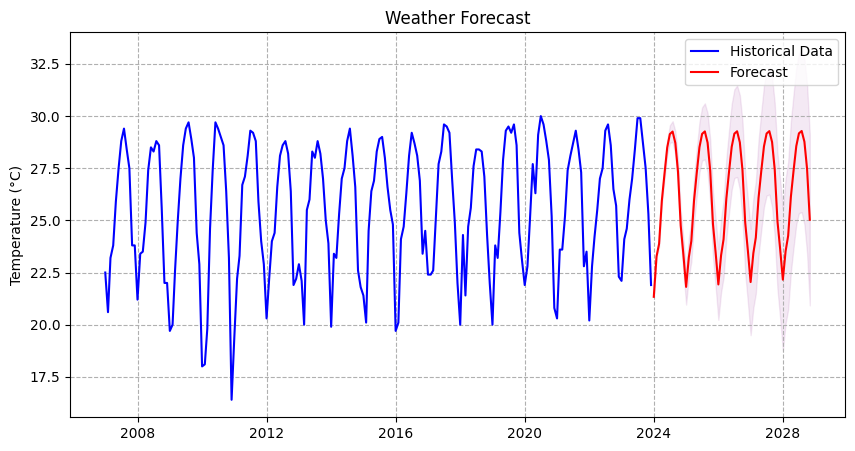

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(extended_weather2['TEMPERATURE'], label='Historical Data', color='blue')
plt.plot(filtered_data.index, filtered_data['DIFF_FORECAST'], label='Forecast', color='red')
num_points = len(filtered_data['DIFF_FORECAST'])
dynamic_std_dev = np.linspace(0, filtered_data['DIFF_FORECAST'].std() * 1.65, num_points)
plt.fill_between(filtered_data.index,
                 filtered_data['DIFF_FORECAST'] - dynamic_std_dev,
                 filtered_data['DIFF_FORECAST'] + dynamic_std_dev,
                 color='purple', alpha=0.085)
plt.title('Weather Forecast')
plt.ylabel('Temperature (°C)')
plt.grid(True, linestyle='--')
plt.legend()
plt.show()